# FathomNet Models
*So you want to use FathomNet models...*

<img src="https://raw.githubusercontent.com/fathomnet/fathomnet-logo/main/FathomNet_white_CenterText_400px.png" alt="FathomNet logo" width="200"/>

## Introduction

This notebook is designed to demonstrate usage of the **FathomNet Models**, available for use at https://huggingface.co/FathomNet.
The FathomNet Models are trained on the [FathomNet Database](https://database.fathomnet.org), a large-scale, open-access dataset of underwater images and annotations.

It's split into three parts:
1. [**Download**](#download): Download one of the **FathomNet Models** from Hugging Face
2. [**Evaluate**](#evaluate): Evaluate the model on a subset of the FathomNet Database
3. [**Run Inference**](#run-inference): Run your own images and/or video through the model

✅ **Before getting started, ensure that the selected runtime has a GPU, otherwise inference will be slow!** In Google Colab, this can be configured with `Runtime -> Change runtime type`, and select at least the `T4 GPU` for hardware acceleration.

<a name="setup"></a>
## ⚙️ Setup

Before we get started, let's install and import a few dependencies. Run the following cells once.

In [ ]:
%pip install -q -U fathomnet huggingface_hub ultralytics lapx dill

In [ ]:
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

<a name="download"></a>
## 📥 Download

Let's download one of the **FathomNet Models** from Hugging Face.

As of the time of this writing, the following models are available:

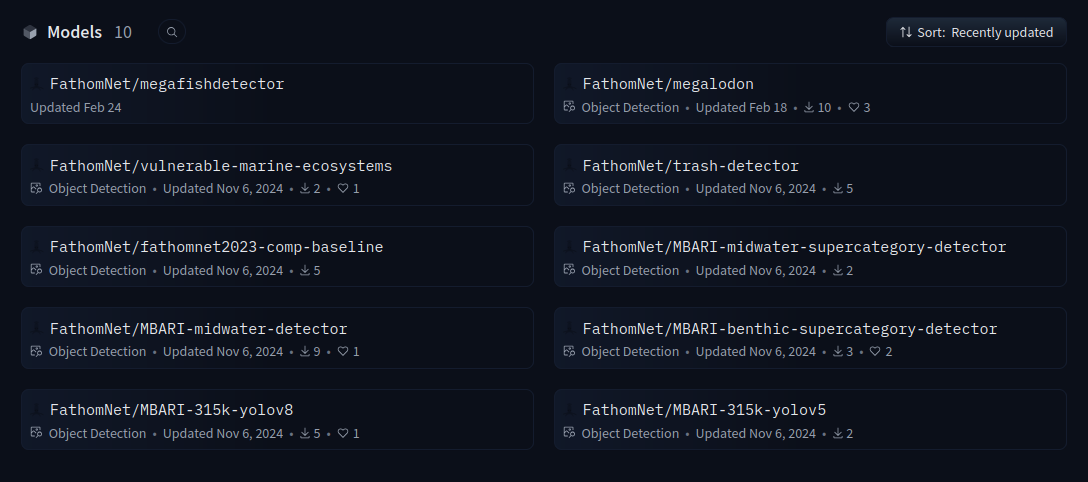

For this notebook, let's look at one of the available YOLOv8 models. We'll use the `ultralytics` Python package to run model validation and inference later-on.

### Select a Model

⚙ **From the dropdown below, select a model to download. The default is `Megalodon`.** Note that the [Evaluate](#evaluate) section of this notebook expects that you're using the Megalodon model, but feel free to experiment.

In [ ]:
model_options = [
    ("Megalodon", ("FathomNet/megalodon", "mbari-megalodon-yolov8x.pt")),
    ("MBARI 315k", ("FathomNet/MBARI-315k-yolov8", "mbari_315k_yolov8.pt")),
    (
        "Trash Detector",
        (
            "FathomNet/trash-detector",
            "trash_mbari_09072023_640imgsz_50epochs_yolov8.pt",
        ),
    ),
]

model_dropdown = widgets.Dropdown(
    options=model_options,
    value=model_options[0][1],
    description="Model:",
)

display(model_dropdown)

### Download Weights

Now that we have a model selected, let's download its weights from Hugging Face.

*Note:* Make sure to re-run this cell if you change the model in the dropdown above.

In [ ]:
from huggingface_hub import hf_hub_download

repo_id, filename = model_dropdown.value
model_path = hf_hub_download(
    repo_id=repo_id,
    filename=filename,
    cache_dir=".",
)
print(f"{repo_id} downloaded to {model_path}")

<a name="evaluate"></a>
## 🧪 Evaluate

Now that we have the model downloaded, let's evaluate it on a subset of the **[FathomNet Database](https://database.fathomnet.org/)**.

We'll first grab a set of images and annotations from the Database using the [`fathomnet-generate`](https://fathomnet-py.readthedocs.io/en/latest/scripts.html#fathomnet-generate) command (installed from [fathomnet-py](https://github.com/fathomnet/fathomnet-py)).

⚙ **Try changing the concept below!** One with a small set of images has been pre-selected for a quick download.

In [ ]:
import re

concept = "Mitrocoma"

print("Dataset preview:")
!fathomnet-generate -c '{concept}' --count
print()

val_dataset_path = re.sub(r"\W", "_", concept)

!fathomnet-generate -c '{concept}' \
    --img-download {val_dataset_path}/images \
    -o /content/{val_dataset_path} \
    -f yolo

print(f"\nDownloaded dataset to {val_dataset_path}")

Great! Now that we have a dataset downloaded and formatted, we can run the validation. We'll load the model we downloaded earlier and call its `val` method to run inference and compute performance metrics against our dataset.

This method will run inference on each of the images in our dataset, compare the model's predictions against the annotations, and compute metrics that help us understand how the model is performing.

Since the images and annotations we're using here may have been part of the model's training data, **these metrics should not be considered a proper evaluation of the model.** These are simply used for convenience to show the evaluation process. A proper evaluation would involve a separate test dataset that matches the target distribution of the intended deployment.

In [ ]:
from ultralytics import YOLO

print(f"Loading model from {model_path}")
model = YOLO(model_path)

metrics = model.val(
    data=f"{val_dataset_path}/dataset.yaml",
    project=f"{val_dataset_path}/runs",
)

### Visualize

Above, you can see some of the metrics printed out from the evaluation process. This process also saves some plots to give insight into the model performance. Let's visualize them.

In [ ]:
from PIL import Image

# Open the generated plots
f1_curve = Image.open(f"{metrics.save_dir}/F1_curve.png")
pr_curve = Image.open(f"{metrics.save_dir}/PR_curve.png")
p_curve = Image.open(f"{metrics.save_dir}/P_curve.png")
r_curve = Image.open(f"{metrics.save_dir}/R_curve.png")
confusion_matrix = Image.open(f"{metrics.save_dir}/confusion_matrix.png")
val_batch0_labels = Image.open(f"{metrics.save_dir}/val_batch0_labels.jpg")
val_batch0_pred = Image.open(f"{metrics.save_dir}/val_batch0_pred.jpg")

# Grid the F1, PR, P, R curves with the confusion matrix
grid_height = f1_curve.size[1] + pr_curve.size[1]

# Scale the confusion matrix to grid_height
conf_scale = grid_height / confusion_matrix.size[1]
confusion_matrix = confusion_matrix.resize(
    (
        int(confusion_matrix.size[0] * conf_scale),
        int(confusion_matrix.size[1] * conf_scale),
    )
)

grid_width = f1_curve.size[0] + pr_curve.size[0] + confusion_matrix.size[0]

grid_image = Image.new("RGB", size=(grid_width, grid_height))
grid_image.paste(p_curve, (0, 0))
grid_image.paste(r_curve, (f1_curve.size[0], 0))
grid_image.paste(f1_curve, (0, p_curve.size[1]))
grid_image.paste(pr_curve, (f1_curve.size[0], p_curve.size[1]))
grid_image.paste(confusion_matrix, (f1_curve.size[0] + pr_curve.size[0], 0))

# Scale down the grid image
scale = 0.25
grid_image = grid_image.resize(
    (int(grid_image.size[0] * scale), int(grid_image.size[1] * scale))
)

# Display the grid image
display(grid_image)

- **Precision-Confidence Curve**: shows the relationship of the confidence threshold to the **precision**. For the Megalodon model, the precision represents the proportion of boxes that the model predicted that were actually on a valid object. Precision decreases when the model predicts something in the background as an object. As the confidence threshold increases, the model predicts fewer boxes (being more selective) which makes for higher precision.
- **Recall-Confidence Curve**: shows the relationship of the confidence threshold to the **recall**. For the Megalodon model, the recall represents the proportion of ground-truth objects that the model correctly detected. Recall decreases when the model "misses" an object. As the confidence threshold increases, the model predicts fewer boxes which makes for lower recall.
- **F1-Confidence Curve**: shows the relationship of the confidence threshold to the **F1-score**. The F1-score is the harmonic mean of the precision and recall, represening an even "blend" of the two metrics. The peak of this curve is generally selected as the "sweet spot" for a confidence threshold, though this depends on the use case.
- **Precision-Recall Curve**: shows the relationship between precision and recall across different confidence thresholds.
- **Confusion Matrix**: shows the number of predictions in each category versus the ground truth.

<a name="run-inference"></a>
## 🚀 Run Inference

Now that we have a sense of how the model performs, let's try running it to generate predictions on new data.

**If you have your own set of images or video, now's the time to upload them.**

1. **If your files are local**, use the "Upload to session storage" button (file with up arrow icon).
2. **If your files are on Google Drive**, you can mount them using the "Mount Drive" button.
3. **If your imagery is web-accessible via a URL**, the notebook can download it for you.

⚙ **Run the cell below and set the source to the path or URL to your file. If you have several files, enter the path to the directory.**

You can open the file browser with the folder icon on the left sidebar. If you don't have any data to try with, a sample of 5 images is downloaded under `default_images`.

In [ ]:
import requests
from pathlib import Path

default_urls = [
    "https://database.fathomnet.org/static/m3/framegrabs/Tiburon/stills/2001/312/12_42_31_28.png",
    "https://database.fathomnet.org/static/m3/framegrabs/Ventana/images/3663/01_33_46_21.png",
    "https://oer.hpc.msstate.edu/FathomNet/BenthicAnimalGuide_training/Paragorgiidae032_trimmed.png",
    "https://oer.hpc.msstate.edu/FathomNet/BenthicAnimalGuide_training/Paragorgiidae053_trimmed.png",
    "https://database.fathomnet.org/static/m3/framegrabs/Doc%20Ricketts/images/1038/20180714T151604Z-514be90b-3562-4bf7-aa72-adbe1f1a4949.png",
]
default_images_dir = Path("default_images")
default_images_dir.mkdir(exist_ok=True, parents=True)
for i, url in enumerate(default_urls):
    file_path = default_images_dir / f"default_{i}.png"
    if not file_path.exists():
        with open(file_path, "wb") as f:
            f.write(requests.get(url).content)

source_widget = widgets.Text(
    value=str(default_images_dir.resolve()),
    placeholder="Image, video, directory, or text file path",
    description="Source:",
)
display(source_widget)

With an inference source selected above (use `/content/default_images` if you don't have one), run the following cell to ensure the data is available for inference.

In [ ]:
from ultralytics.data import load_inference_source

# Check the inference source; will download from a URL if necessary
source = source_widget.value
dataset = load_inference_source(source)

n_images = dataset.ni
n_videos = dataset.nf - n_images
print(f"Inference source contains {n_images} image(s) and {n_videos} video(s)")

Now, let's load the model again and run inference.

⚙ **Try changing the parameters from their default values to see how it affects the results!**

⚙ **Try downloading a different model and run this cell again!**

In [ ]:
from ultralytics import YOLO

# Load the model
model = YOLO(model_path)

# Set inference parameters
conf = 0.25  # @param {type:"slider", min:0.05, max:0.95, step:0.05}
iou = 0.7  # @param {type:"slider", min:0.05, max:0.95, step:0.05}
imgsz = 640  # @param [640, 960, 1280]
half = False  # @param {type:"boolean"}
vid_stride = 1  # @param {type:"slider", min:1, max:60, step:1}
agnostic_nms = False  # @param {type:"boolean"}

print("Running inference with parameters:")
print(f"- confidence threshold: {conf}")
print(f"- IoU threshold: {iou}")
print(f"- image size: {imgsz}x{imgsz} px")
print(f"- half precision: {'ON' if half else 'OFF'}")
print(f"- video stride: {vid_stride} frame(s)")
print(f"- agnostic NMS: {'ON' if agnostic_nms else 'OFF'}")

# Run inference
results = model.predict(
    source=source,
    save=True,
    project="inference",
    conf=conf,
    iou=iou,
    imgsz=imgsz,
    half=half,
    vid_stride=vid_stride,
    agnostic_nms=agnostic_nms,
)

### Visualize

Lastly, let's visualize some results!

In [ ]:
from random import sample

# Collect output images and videos
save_dir = results[0].save_dir
output_images = list(Path(save_dir).glob("*.jpg"))
output_videos = list(Path(save_dir).glob("*.avi"))

image_widgets = []

if output_images:
    # Select a random set of images to display
    images_to_display = sample(output_images, min(30, len(output_images)))
    for image_path in sorted(images_to_display):
        with open(image_path, "rb") as f:
            image_widgets.append(widgets.Image(value=f.read()))

image_grid = widgets.GridBox(
    image_widgets, layout=widgets.Layout(grid_template_columns="repeat(3, 500px)")
)
display(image_grid)

if output_videos:
    # Select a random video to display
    video_path = sample(output_videos, 1)[0]
    video_widget = widgets.Video.from_file(video_path)
    display(video_widget)

## Conclusion

To wrap up, this notebook showed how to download the [FathomNet Models](https://huggingface.co/FathomNet), evaluate their performance, and run inference on both images and video. 

We covered:
- setting up the environment,
- loading the models, 
- downloading an evaluation dataset,
- running evaluation on the dataset,
- visualizing the evaluation results,
- and running inference on custom data.

---

This notebook provides a basic foundation for using FathomNet models in your own projects or integrating them into larger image and video analysis workflows.

For more information on the FathomNet program and its mission to accelerate ocean discovery with artificial intelligence, see [fathomnet.org](https://fathomnet.org).